In [1]:
import sys
import logging
import pickle
import yaml
import matplotlib.cm as cm
from joblib import Parallel, delayed
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
import os
import time
import configs
import seaborn as sns
import pandas as pd

# Parameters

In [2]:
episodes = [0, 100, 200, 300, 400, 500, 600]

In [28]:
internal_dim = 10
generic_exp_name = 'new_gridworld8x8_shuffobs'
network_yaml = 'dm'

In [29]:
engram_dir = '/Volumes/aronov-locker/Ching/rl/'
engram_dir = '/mnt/smb/locker/aronov-locker/Ching/rl/' # Axon path
exp_name = f'{generic_exp_name}_{network_yaml}_dim{internal_dim}'
nnets_dir = f'{engram_dir}nnets/{exp_name}/'
pickle_dir = f'{engram_dir}pickles/{exp_name}/'
analysis_dir = f'{engram_dir}analysis/{exp_name}/'

In [30]:
models = ['mf0', 'g0_-2_entro-1', 'entro0']

# Load analysis

In [31]:
dfs = []
for episode in episodes:
    with open(f'{analysis_dir}representation_df_ep{episode}.p', 'rb') as f:
        repr_df = pickle.load(f)
    repr_df.model = repr_df.model.str[len(generic_exp_name)+1:]
    repr_df['episode'] = episode
    dfs.append(repr_df)
dfs = pd.concat(dfs)

In [32]:
results = {
    'inner product': [],
    'model': [],
    'episode': []
    }
for i in np.unique(dfs['iteration']):
    df = dfs[dfs['iteration']==i]
    goal_state = dfs.iloc[0]['goal_state']
    
    # Collect relevant states
    xys = []
    for x in np.unique(df['x']):
        for y in np.unique(df['y']):
            if [x, y] == goal_state: continue
            xys.append([x,y])
    
    # Get pairwise angles
    for idx_1, xy1 in enumerate(xys):
        for xy2 in xys[idx_1+1:]:
            df_xy1 = df[(df['x']==xy1[0])&(df['y']==xy1[1])]
            df_xy2 = df[(df['x']==xy2[0])&(df['y']==xy2[1])]
            for model in models:
                df_xy1_model = df_xy1[df_xy1['model']==model]
                df_xy2_model = df_xy2[df_xy2['model']==model]
                for episode in episodes:
                    _df1 = df_xy1_model[df_xy1_model['episode']==episode]
                    _df2 = df_xy2_model[df_xy2_model['episode']==episode]
                    if len(_df1.index) == 0: continue
                    assert(len(_df1.index)==1)
                    assert(len(_df2.index)==1)
                    arr1 = np.array(_df1.iloc[0]['latents'])
                    arr2 = np.array(_df2.iloc[0]['latents'])
                    sim = np.dot(arr1, arr2)/(np.linalg.norm(arr1)*np.linalg.norm(arr2))
                    results['inner product'].append(sim)
                    results['model'].append(model)
                    results['episode'].append(episode)

In [33]:
df = pd.DataFrame(results)

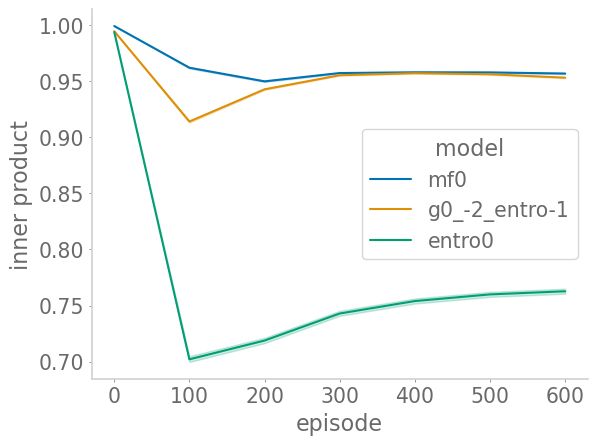

In [34]:
plt.figure()
sns.lineplot(y='inner product', x='episode',
    hue_order=models, hue='model', data=df)
plt.show()